# MANUela Anomaly ML Model

Goal: Build a machine lerning model that detects anomalies in sensor vibration data

![anomalies](https://raw.githubusercontent.com/sa-mw-dach/manuela/master/docs/images/manuela-anomalies.png)

- refer to this link: https://tinyurl.com/yd4mngxw
- Sklern: For supervised and unsupervised learning. This library provides various tools for model fitting, data preprocessing, model selection, and model evaluation. It has built-in machine learning algorithms and models called estimators. Each estimator can be fitted to some data using its fit method.

In [53]:
import numpy as np
import sys
sys.path.append("D:/code")
import thaFileLammps, thaTool, thaModel
from itertools import combinations

########## create graphene sheet ####
P1,Ang1,Box1,lC1,lT1 = thaModel.fGrapheneLattice(5, 5, bondCC=1.421, Size=[20,20], Sheetnumber=1, bondPlane=3.35)
P2,Ang2,Box2,lC2,lT2 = thaModel.fGrapheneLattice(5, 5, bondCC=1.421, Size=[20,20], Sheetnumber=1, bondPlane=3.35, SimeGraphene=True)

P2[:,2] = P2[:,2] + 2
Box = Box1; Box[2,1] = Box[2,1] + (Box2[2,1] -Box2[2,0])

## make Grid on Box2
atomIDinCell,_ = thaTool.f2dGridBox(P2, Box2, plane='XY', mode='binNumbers', gridValue=[3,3])
print(atomIDinCell)

[array([ 0,  5,  6, 11, 13, 14, 16, 21, 22, 51, 53, 54])
 array([24, 29, 30, 35, 37, 38, 40, 45, 46])
 array([59, 61, 62, 64, 69, 70, 75, 77, 78])
 array([ 3,  4,  7, 12, 15, 19, 20, 23, 52, 55])
 array([27, 28, 31, 36, 39, 43, 44, 47])
 array([60, 63, 67, 68, 71, 76, 79])
 array([ 1,  2,  8,  9, 10, 17, 18, 48, 49, 50])
 array([25, 26, 32, 33, 34, 41, 42])
 array([56, 57, 58, 65, 66, 72, 73, 74])]


# Using a Jupyter notebook for machine learning
- using the [MANUela ML model](https://github.com/sa-mw-dach/manuela-dev/blob/master/ml-models/anomaly-detection/Anomaly-Detection-simple-ML-Training.ipynb) as a notebook example to explore various components needed for machine learning. The data used to train the model is located in the [raw-data.csv](https://github.com/sa-mw-dach/manuela-dev/blob/master/ml-models/anomaly-detection/raw-data.csv) file.

Outlines: 
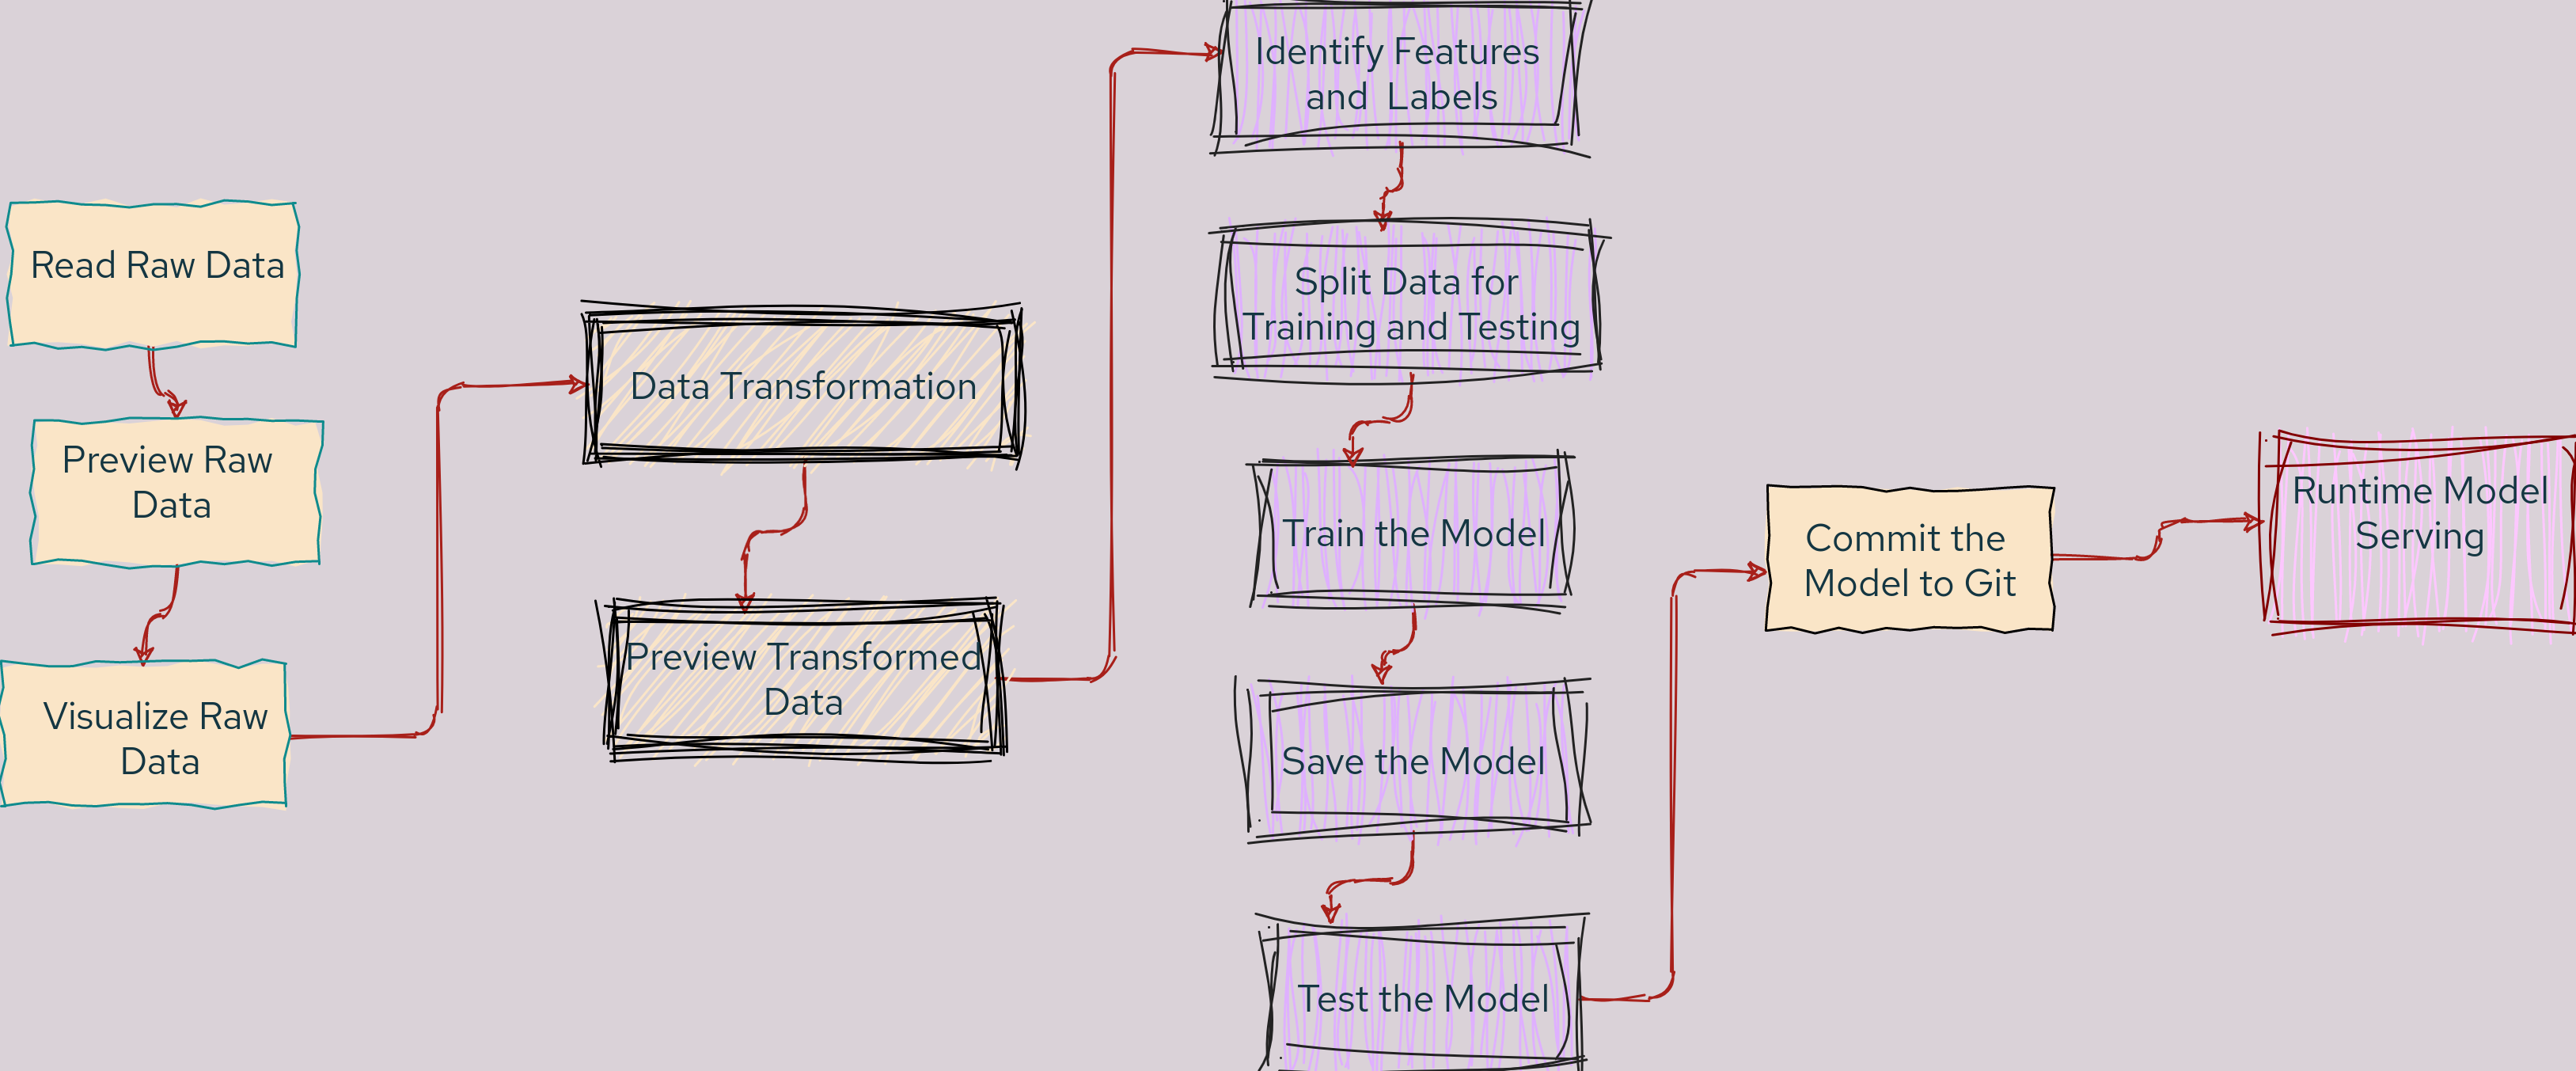

## Step 1: Read raw data
convert the raw data file (raw-data.csv) to a DataFrame with a time series, an ID for the pump, a vibration value, and a label indicating an anomaly.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('raw-data.csv')
df.tail(5)

,ts,id,value,label
3017,1587647978000,pump-2,43.276667,1
3018,1587647979617,pump-1,15.709151,0
3019,1587647982999,pump-2,16.214949,0
3020,1587647984617,pump-1,15.393048,0
3021,1587647987999,pump-2,14.855999,0


### Preview the raw data
It is a dataframe with a
- timeseries,
- an id for the pump,
- the vibration value
- and a label indicating an anmonaly.

In [4]:
df['time'] = pd.to_datetime(df['ts'],unit='ms')
df.set_index('time', inplace=True)
df.drop(columns=['ts'], inplace=True)
df.tail(5)

,id,value,label
time,,,
2020-04-23 13:19:38.000,pump-2,43.276667,1
2020-04-23 13:19:39.617,pump-1,15.709151,0
2020-04-23 13:19:42.999,pump-2,16.214949,0
2020-04-23 13:19:44.617,pump-1,15.393048,0
2020-04-23 13:19:47.999,pump-2,14.855999,0


### Visualize data
- The uppper graph show a subset of the vibration data.
- The lower graph illustrates the anomalies (1 = anomaly, 0 = normal).These are the anomalies that the machine learning model should detect.

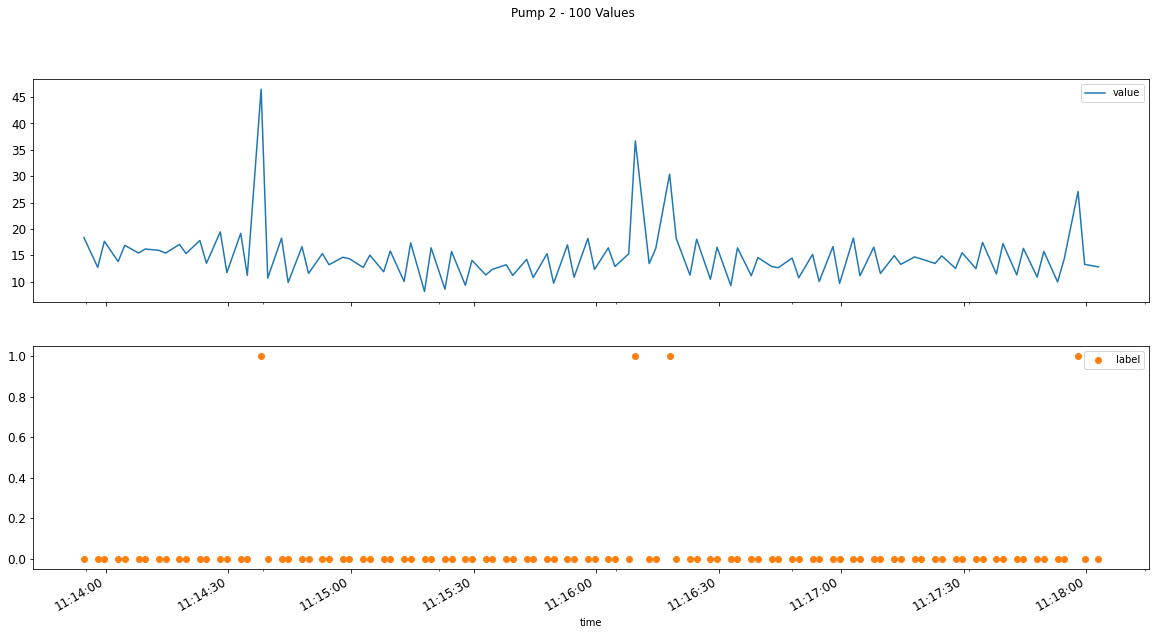

In [5]:
df21 = df.head(100)
df21.plot(figsize=(20,10), fontsize=12,subplots=True, style=["-","o"], title = "Pump 2 - 100 Values")
plt.show()

### Data wrangling
Before it can be analyzed, the raw data needs to be transformed, cleaned, and structured into other formats more suitable for analysis. This process is called data wrangling or data munging.

Goal: Convert time series data into small episodes that can be uses for supervised learning.

In [8]:
## Few helper functions
# Get list with column names: F1, F2, Fn, L
def get_columns(n):
    f = []
    for x in range(1,n+1):
        f.append("F"+str(x))
    f.append("L")
    return f

# Create empty data frame
def create_empty_df(n):
    d= ([0.]*n)
    d.append(0)
    dfx = pd.DataFrame([d], columns=get_columns(n))
    dfx.drop(dfx.index[0], inplace=True)
    return dfx

# Create data frame with one row
def create_df(vals: list, label: int = 0):
    if not isinstance(vals, list):
        raise TypeError
    #vals.append(label)    
    dfx = pd.DataFrame([vals+[label]], columns=get_columns(len(vals)))
    return dfx

In [13]:
f= create_empty_df(5)
f

,F1,F2,F3,F4,F5,L


In [9]:
length = 5 # Episode lenght

df_epis = create_empty_df(length)

for id in df.id.unique():
    print("Convert data for: ", id)
    
    df2 = df.loc[df['id'] == id]

    epi = []
    for index, row in df2.iterrows():
        # print('%6.2f, %d' % (row['value'], row['label']))
        epi.append(row['value'])
        if len(epi) == length :
            df_row = create_df(epi,row['label'] )
            df_epis = df_epis.append(df_row, ignore_index=True)
            del(epi[0])

Convert data for:  pump-1
Convert data for:  pump-2


### new data format
the raw data is now presented with episodes of length 5 and the label in the last column.

In [16]:
df_epis

,F1,F2,F3,F4,F5,L
0,18.340181,17.647661,16.874933,16.180807,15.407113,0
1,17.647661,16.874933,16.180807,15.407113,15.324012,0
2,16.874933,16.180807,15.407113,15.324012,13.470387,0
3,16.180807,15.407113,15.324012,13.470387,11.702384,0
4,15.407113,15.324012,13.470387,11.702384,11.176102,0
...,...,...,...,...,...,...
3009,12.804910,14.626118,14.697982,16.386558,17.361092,0
3010,14.626118,14.697982,16.386558,17.361092,18.764962,0
3011,14.697982,16.386558,17.361092,18.764962,43.276667,1
3012,16.386558,17.361092,18.764962,43.276667,16.214949,0


## Step 2: Prepare the data for modeling, training and testing
- Identify and separate the feature and target columns
- Training and Testing Data Split
### 1. Identify Feature and target columns
Like many machine learning libraries, Sklern requires separated feature (X) and target (Y) columns. 

In [17]:
# Extract feature columns
feature_cols = list(df_epis.columns[:-1])

# Extract target column 'label'
target_col = df_epis.columns[-1] 

# Show the list of columns
print ("Feature columns:\n{}".format(feature_cols))
print ("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = df_epis[feature_cols]
y_all = df_epis[target_col]

# Show the feature information by printing the first five rows
print ("\nFeature values:")
print (X_all.head())

Feature columns:
['F1', 'F2', 'F3', 'F4', 'F5']

Target column: L

Feature values:
          F1         F2         F3         F4         F5
0  18.340181  17.647661  16.874933  16.180807  15.407113
1  17.647661  16.874933  16.180807  15.407113  15.324012
2  16.874933  16.180807  15.407113  15.324012  13.470387
3  16.180807  15.407113  15.324012  13.470387  11.702384
4  15.407113  15.324012  13.470387  11.702384  11.176102


### 2. Training and testing data Split
It’s a good practice to divide your data set into two subsets: One to train a model and the other to test the trained model.

Our goal is to create a model that generalizes well to new data. Our test set will serve as a proxy for new data. We’ll split the data set into 67% for the training sets and 33% for the test set

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X_all, y_all, test_size=0.33, random_state=42)


# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

print ("Anomaly rate of the training set: {:.2f}%".format(100 * (y_train == 1).mean()))
print ("Anomaly rate of the testing set: {:.2f}%".format(100 * (y_test == 1).mean()))

Training set has 2019 samples.
Testing set has 995 samples.
Anomaly rate of the training set: 2.72%
Anomaly rate of the testing set: 2.91%


### 3. Model training
We will perform model training with a DecisionTreeClassifier. Decision Trees is a supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

In [21]:
# from sklearn import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

my_random_seed = 42

# Initialize the DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=my_random_seed)

# train the classifier
model.fit(X_train, y_train)

# Predict with the test data
y_predict = model.predict(X_test)

# Determine the accuracy score
accuracy_score = accuracy_score(y_test, y_predict)

print ("Accuracy score for the trained model: {:.4f}.".format(accuracy_score))

Accuracy score for the trained model: 1.0000.


### 4. Save model to disk
- Save the model
- Load the model again and check that it works

In [22]:
from joblib import dump, load

filename = 'model.joblib'
dump(model, open(filename, 'wb'))

# Validate that the model can be loaded

# load the model from disk
loaded_model = load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print("Score:", result)

Score: 1.0
